dFF samples: 93696, Fs ≈ 300.00 Hz
dFF struct fields: ['data', 'Fs', 'Ts']
Candidates: ['#refs#/0', '#refs#/0b', '#refs#/0c', '#refs#/0d', '#refs#/0e', '#refs#/0f', '#refs#/0g', '#refs#/0h', '#refs#/0i', '#refs#/0j', '#refs#/0k', '#refs#/0l', '#refs#/0m', '#refs#/0n', '#refs#/0o', '#refs#/1', '#refs#/1b', '#refs#/1c', '#refs#/1d', '#refs#/1e', '#refs#/1f', '#refs#/1g', '#refs#/1h', '#refs#/1i', '#refs#/1j', '#refs#/1k', '#refs#/1l', '#refs#/1m', '#refs#/1n', '#refs#/1o', '#refs#/2', '#refs#/2b', '#refs#/2c', '#refs#/2d', '#refs#/2e', '#refs#/2f', '#refs#/2g', '#refs#/2h', '#refs#/2i', '#refs#/2j', '#refs#/2k', '#refs#/2l', '#refs#/2m', '#refs#/2n', '#refs#/2o', '#refs#/3', '#refs#/3b', '#refs#/3c', '#refs#/3d', '#refs#/3e', '#refs#/3f', '#refs#/3g', '#refs#/3h', '#refs#/3i', '#refs#/3j', '#refs#/3k', '#refs#/3l', '#refs#/3m', '#refs#/3n', '#refs#/3o', '#refs#/4', '#refs#/4b', '#refs#/4c', '#refs#/4d', '#refs#/4e', '#refs#/4f', '#refs#/4g', '#refs#/4h', '#refs#/4i', '#refs#/4j', '#refs#

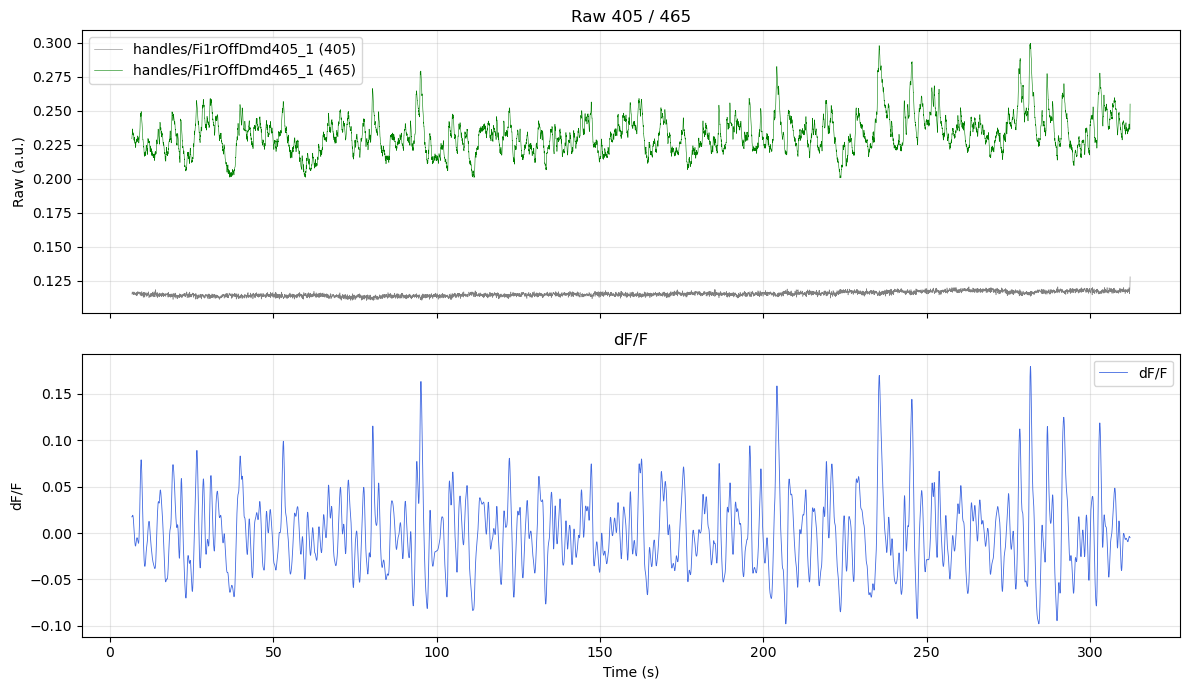

In [19]:
import numpy as np
import pandas as pd
import h5py
from scipy.io import loadmat
import matplotlib.pyplot as plt

# ----------- Paths -----------
dFF_file_path = r"E:\DA_comparison\Data\Ayano_setup_Ayano_room\k1818_k00_k00_k00-251119-140644\Mouse-251208-142347\Session_Mouse-251208-142347_dFF.mat"
RAW_file_path = r"E:\DA_comparison\Data\Ayano_setup_Ayano_room\k1818_k00_k00_k00-251119-140644\Mouse-251208-142347\Session_Mouse-251208-142347_UnivRAW_offdemod.mat"
box = 0  # 0=box1, 1=box2, ...

# ----------- Load timebase and event timings from RAW -----------
with h5py.File(RAW_file_path, "r") as f_raw:
    ts_refs = f_raw["/handles/Ts"]            # cell array of references
    ts_abs = np.array(f_raw[np.ravel(ts_refs)[box]]).squeeze()
    strobe_timing = f_raw["handles"]["Tr_1_on"][0]
    lick_timing = f_raw["handles"]["Tr_2_on"][0]
    reward_timing = f_raw["handles"]["Op_2_on"][0]

dff_time_sec = ts_abs  # normalized time was 0–1; ts_abs restores seconds

# ----------- Load dFF (pair 0 = 465/405) -----------
mat_data = loadmat(dFF_file_path, squeeze_me=True, struct_as_record=False)
if "dFFOut" in mat_data:                      # stage2 file with all boxes
    dff_struct = mat_data["dFFOut"].box[box].pair[0]
elif "dFF" in mat_data:                       # per-box dFF file
    dff_struct = mat_data["dFF"].pair[0]
else:
    raise KeyError("No dFF/dFFOut found in MAT file")

dff_vals = np.array(dff_struct.data).squeeze()
sampling_rate = len(dff_vals) / dff_time_sec[-1]
print(f"dFF samples: {len(dff_vals)}, Fs ≈ {sampling_rate:.2f} Hz")
print("dFF struct fields:", getattr(dff_struct, "_fieldnames", getattr(dff_struct, "__dict__", {})))

# ----------- Find and load raw 405/465 from RAW H5 -----------
with h5py.File(RAW_file_path, "r") as f_raw:
    found = []
    def _vis(name, obj):
        lname = name.lower()
        if isinstance(obj, h5py.Dataset) and ("405" in lname or "465" in lname or "ref" in lname or "signal" in lname):
            found.append(name)
    f_raw.visititems(_vis)
    print("Candidates:", found)

    cand_405 = [k for k in found if "405" in k.lower()]
    cand_465 = [k for k in found if "465" in k.lower()]
    if not cand_405 or not cand_465:
        raise RuntimeError("No 405/465 datasets found; pick paths from Candidates and set cand_405/cand_465 manually.")

    raw405 = np.array(f_raw[cand_405[0]]).squeeze()
    raw465 = np.array(f_raw[cand_465[0]]).squeeze()

# Trim to same length and build time vector on raw grid
n = min(len(raw405), len(raw465))
raw405 = raw405[:n]
raw465 = raw465[:n]
t_raw = np.linspace(dff_time_sec[0], dff_time_sec[-1], n)

# ----------- Combined plots -----------
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

axes[0].plot(t_raw[2000:], raw405[2000:], color="gray", lw=0.4, label=f"{cand_405[0]} (405)")
axes[0].plot(t_raw[2000:], raw465[2000:], color="green", lw=0.4, label=f"{cand_465[0]} (465)")
axes[0].set_ylabel("Raw (a.u.)")
axes[0].set_title("Raw 405 / 465")
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].plot(dff_time_sec[2000:], dff_vals[2000:], color="royalblue", lw=0.6, label="dF/F")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("dF/F")
axes[1].set_title("dF/F")
axes[1].grid(alpha=0.3)
axes[1].legend()

fig.tight_layout()
plt.show()
# Optional save:
fig.savefig(r"E:\DA_comparison\Data\Ayano_setup_Ayano_room\1818_Ayanoroom_full_session_dFF.png", dpi=300)
